# TODO:
- ile potrzeba iteracji (random seach, bayes) do uzyskania stabilncyh wyników - DONE
- trzeba się zastanowić jakie zakres hyper parametrów bierzemy - ADAM -TODO
- używać cross validacjei zamiast zwykłego fit - JANEK - DONE? chyba nie da rady bo cross_val_score nie zwraca modelu, więc nie da się go użyć do predykcji...
- określić i przeanalizować tunowalność CAŁYCH algorytmów - DONE
- sprawdić jak zmiana seed w random search wpływa na wyniki tunowalnośći (sampling bias) - TODO (zmienaimy seed i patrzymy czy tunowalność się zmienia -> tabelka z 10 seedami i patrzyma jak zmienia się tunowalnosć) -TODO ( przy pisaniu raportu)
- refactor -> notbook per algorithm - TODO
- PING dla kozak o co chodzi z folder WYNIKI + co w raporci - TODO - ADAM

### Imports

In [2]:
import itertools
import random
from typing import Any, Dict, List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas import DataFrame, Series
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet

# from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from skopt import BayesSearchCV
from skopt.space import Integer, Real

from utills.dataset import load_dataset_from_id, split_dataset
from utills.pipeline import (
    get_bayes_model,
    get_column_transformer,
)

### Utill functions

In [3]:
def evaluate_model(model: Pipeline, X_train, y_train, X_test, y_test) -> float:
    model.fit(
        X=X_train,
        y=y_train,
    )
    return model.score(
        X=X_test,
        y=y_test,
    )

In [4]:
def evaluate_config_on_each_dataset(
    train_datasets: List[Tuple[DataFrame, Series]],
    test_datasets: List[Tuple[DataFrame, Series]],
    model: Pipeline,
    config,
) -> List[float]:
    performances: List[float] = []
    for (X_train, y_train), (X_test, y_test) in zip(train_datasets, test_datasets):
        model.set_params(**config)
        performance: float = evaluate_model(
            model=model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test
        )
        performances.append(performance)
    return performances

In [5]:
def find_optimal_configuration_for_all_datasets(
    config_space,
    train_datasets: List[Tuple[DataFrame, Series]],
    test_datasets: List[Tuple[DataFrame, Series]],
    model: Pipeline,
    summary_func,
) -> Tuple[Any, List[float]]:
    best_config = None
    best_summary_score = float("0")
    history_scores: List[float] = []
    for config in config_space:
        scores: List[float] = evaluate_config_on_each_dataset(
            train_datasets=train_datasets,
            test_datasets=test_datasets,
            model=model,
            config=config,
        )
        summary_score = summary_func(scores)
        history_scores.append(summary_score)
        if summary_score > best_summary_score:
            best_summary_score = summary_score
            best_config = config

    return (best_config, history_scores)

In [6]:
def find_best_config_for_dataset_with_random_search(
    config_space,
    train_dataset: Tuple[DataFrame, Series],
    test_dataset: Tuple[DataFrame, Series],
    model: Pipeline,
):
    best_config = None
    best_score = float("0")

    for config in config_space:
        model.set_params(**config)
        score: float = evaluate_model(
            model=model,
            X_train=train_dataset[0],
            y_train=train_dataset[1],
            X_test=test_dataset[0],
            y_test=test_dataset[1],
        )

        if score > best_score:
            best_score = score
            best_config = config

    return best_config

In [7]:
def find_best_configs_in_search_space_with_random_search(
    pipeline: Pipeline, config_space, train_datasets, test_datasets
):
    best_configs = []
    for i, (train_dataset, test_dataset) in enumerate(
        zip(train_datasets, test_datasets)
    ):
        best_config = find_best_config_for_dataset_with_random_search(
            config_space=config_space,
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            model=pipeline,
        )
        best_configs.append(best_config)
        pipeline.set_params(**best_config)
        pipeline.fit(train_dataset[0], train_dataset[1])
        print("dataset: " + str(i))
        print("score: " + str(pipeline.score(test_dataset[0], test_dataset[1])))
        print("best config: " + str(best_config))
    return best_configs

In [31]:
def find_best_config_using_bayes(
    pipeline: Pipeline,
    search_space: Dict[str, Any],
    X: DataFrame,
    y: DataFrame,
    n_iter,
):
    opt: BayesSearchCV = get_bayes_model(pipeline, search_space, n_iter)
    opt.fit(X, y)
    iteration_scores = opt.cv_results_["mean_test_score"]

    # Optional: Print the score for each iteration
    for i, score in enumerate(iteration_scores):
        print(f"Iteration {i + 1}: Score = {score}")
    print("Best score:", opt.best_score_)
    print(opt.n_iter)
    return (dict(opt.best_params_), iteration_scores)

In [32]:
def find_best_configs_in_search_space_with_bayes(
    search_space, pipeline: Pipeline, train_datasets
):
    configs = []
    history: List[List[float]] = []
    for train in train_datasets:
        config, iteration_scores = find_best_config_using_bayes(
            pipeline, search_space[0], train[0], train[1], search_space[1]
        )
        configs.append(config)
        history.append(iteration_scores)

    return (configs, history)

In [12]:
def calculate_tunability_on_each_set(
    train_datasets, test_datasets, best_configs, optimal_config
):
    tunability = []
    for train_dataset, test_dataset, best_config in zip(
        train_datasets, test_datasets, best_configs
    ):
        optimal_decision_tree: Pipeline = get_decision_tree_pipeline()
        optimal_decision_tree.set_params(**optimal_config)

        optimal_decision_tree.fit(train_dataset[0], train_dataset[1])

        best_decision_tree_for_dataset = get_decision_tree_pipeline()
        best_decision_tree_for_dataset.set_params(**best_config)

        best_decision_tree_for_dataset.fit(train_dataset[0], train_dataset[1])

        tunability_on_dataset = optimal_decision_tree.score(
            test_dataset[0], test_dataset[1]
        ) - best_decision_tree_for_dataset.score(test_dataset[0], test_dataset[1])

        tunability.append(tunability_on_dataset)

        print("d^j: " + str(tunability_on_dataset))
    return tunability

In [13]:
def calculate_aggregate_tunability(tunability):
    return np.mean(tunability)

In [14]:
def plot_tunability_boxplot(tunability):
    tunability_data = [tunability]

    sns.boxplot(data=tunability_data)

    # add strip plot
    sns.stripplot(data=tunability_data, color="black", size=4)

    # add labels and title
    plt.xlabel("Dataset")
    plt.ylabel("Tunability")
    plt.title("Tunability per Dataset")

    # show the plot
    plt.show()

### Load datasets

In [15]:
fish_market_dataset_id = (
    43308  # https://www.openml.org/search?type=data&id=43308&sort=runs&status=active
)
cars_dataset_id = (
    44994  # https://www.openml.org/search?type=data&status=active&id=44994
)
diabetes_dataset_id = (
    44223  # https://www.openml.org/search?type=data&id=44223&sort=runs&status=active
)

lisbona_house_prices_dataset_id = (
    43660  # https://www.openml.org/search?type=data&id=43660&sort=runs&status=active
)


fish_market_dataset: DataFrame = load_dataset_from_id(id=fish_market_dataset_id)
fish_market_regression_class = "Weight"

cars_dataset: DataFrame = load_dataset_from_id(id=cars_dataset_id)
cars_regression_class = "Price"

diabetes_dataset: DataFrame = load_dataset_from_id(id=diabetes_dataset_id)
diabetes_regression_class = "class"

lisbona_house_prices_dataset: DataFrame = load_dataset_from_id(
    id=lisbona_house_prices_dataset_id
)
lisbona_house_prices_regression_class = "Price"

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\openml\datasets\functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` 

### Split data into train and test sets

In [16]:
(
    X_train_fish_market,
    X_test_fish_market,
    y_train_fish_market,
    y_test_fish_market,
) = split_dataset(data=fish_market_dataset, class_=fish_market_regression_class)

(
    X_train_cars,
    X_test_cars,
    y_train_cars,
    y_test_cars,
) = split_dataset(data=cars_dataset, class_=cars_regression_class)

X_train_diabetes, X_test_diabetes, y_train_diabetes, y_test_diabetes = split_dataset(
    diabetes_dataset, diabetes_regression_class
)

(
    X_train_lisbona_house_prices,
    X_test_lisbona_house_prices,
    y_train_lisbona_house_prices,
    y_test_lisbona_house_prices,
) = split_dataset(lisbona_house_prices_dataset, lisbona_house_prices_regression_class)

In [17]:
def get_train_datasets() -> List[Tuple[DataFrame, Series]]:
    return [
        (X_train_fish_market, y_train_fish_market),
        (X_train_cars, y_train_cars),
        (X_train_diabetes, y_train_diabetes),
        (X_train_lisbona_house_prices, y_train_lisbona_house_prices),
    ]

In [18]:
def get_test_datasets():
    return [
        (X_test_fish_market, y_test_fish_market),
        (X_test_cars, y_test_cars),
        (X_test_diabetes, y_test_diabetes),
        (X_test_lisbona_house_prices, y_test_lisbona_house_prices),
    ]


# 1. Decision Tree

## Prepare model and search space

In [19]:
def get_decision_tree_pipeline() -> Pipeline:
    decision_tree = DecisionTreeRegressor()
    col_trans: ColumnTransformer = get_column_transformer()
    decision_tree_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", decision_tree)]
    )
    return decision_tree_pipeline

In [20]:
def get_configuration_grid_decision_tree():
    # parameters space
    random.seed(42)
    ccp_alpha_values = [i * 0.1 for i in range(11)]

    max_depth_values = range(1, 31, 1)

    min_samples_split_values = range(2, 61, 1)

    min_samples_leaf_values = range(1, 61, 1)

    all_combinations = list(
        itertools.product(
            ccp_alpha_values,
            max_depth_values,
            min_samples_split_values,
            min_samples_leaf_values,
        )
    )

    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, 200
    )

    parameter_names = [
        "model__ccp_alpha",
        "model__max_depth",
        "model__min_samples_split",
        "model__min_samples_leaf",
    ]

    config_grid = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]

    return config_grid

In [21]:
train_datasets: List[Tuple[DataFrame, Series]] = get_train_datasets()
test_datasets: List[Tuple[DataFrame, Series]] = get_test_datasets()
decision_tree_pipeline: Pipeline = get_decision_tree_pipeline()
configuration_grid_decision_tree = get_configuration_grid_decision_tree()

## Find optimal default hyperparameters 

In [22]:
# find teta*

(
    optimal_config_decision_tree,
    history_scores,
) = find_optimal_configuration_for_all_datasets(
    config_space=configuration_grid_decision_tree,
    train_datasets=train_datasets,
    test_datasets=test_datasets,
    model=decision_tree_pipeline,
    summary_func=np.mean,  # Or np.median for a more robust approach
)

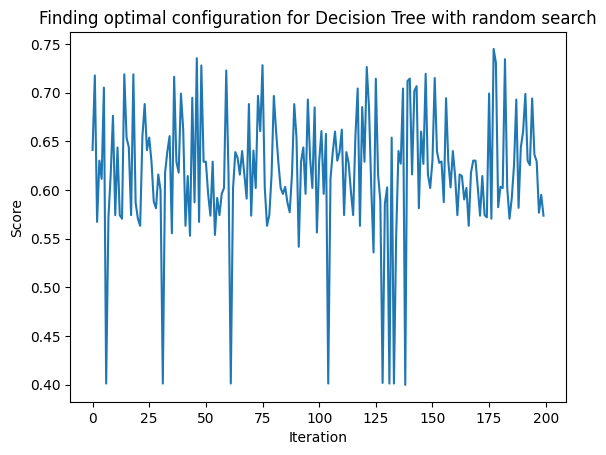

In [23]:
plt.plot(history_scores)
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.title("Finding optimal configuration for Decision Tree with random search")
plt.show()

In [24]:
print(optimal_config_decision_tree)

{'model__ccp_alpha': 0.4, 'model__max_depth': 17, 'model__min_samples_split': 21, 'model__min_samples_leaf': 6}


## Evaluate model with optimal hyperparameters on each dataset

In [25]:
for train_dataset, test_dataset in zip(train_datasets, test_datasets):
    optimal_decision_tree: Pipeline = get_decision_tree_pipeline()
    optimal_decision_tree.set_params(**optimal_config_decision_tree)
    optimal_decision_tree.fit(train_dataset[0], train_dataset[1])
    score = optimal_decision_tree.score(test_dataset[0], test_dataset[1])
    print("Optimal decision tree score on dataset : " + str(score))

Optimal decision tree score on dataset : 0.9463159196695881
Optimal decision tree score on dataset : 0.9179098279573825
Optimal decision tree score on dataset : 0.4417670731137635
Optimal decision tree score on dataset : 0.6736408842842314


## Find best hyperparameters for given dataset with random search

In [26]:
# find tate^(j)*
best_configs_for_each_dataset = find_best_configs_in_search_space_with_random_search(
    pipeline=get_decision_tree_pipeline(),
    config_space=get_configuration_grid_decision_tree(),
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
)

dataset: 0
score: 0.9663130950309771
best config: {'model__ccp_alpha': 0.7000000000000001, 'model__max_depth': 6, 'model__min_samples_split': 4, 'model__min_samples_leaf': 6}
dataset: 1
score: 0.9487023311889127
best config: {'model__ccp_alpha': 0.9, 'model__max_depth': 11, 'model__min_samples_split': 3, 'model__min_samples_leaf': 3}
dataset: 2
score: 0.4692111427031108
best config: {'model__ccp_alpha': 0.4, 'model__max_depth': 7, 'model__min_samples_split': 56, 'model__min_samples_leaf': 8}
dataset: 3
score: 0.698117764128138
best config: {'model__ccp_alpha': 0.7000000000000001, 'model__max_depth': 5, 'model__min_samples_split': 16, 'model__min_samples_leaf': 4}


## Calculate tunability on each dataset

In [27]:
# find d^j
tunability_per_dataset = calculate_tunability_on_each_set(
    train_datasets=get_train_datasets(),
    test_datasets=get_test_datasets(),
    best_configs=best_configs_for_each_dataset,
    optimal_config=optimal_config_decision_tree,
)

d^j: -0.019997175361389008
d^j: -0.030792503231530155
d^j: -0.02744406958934731
d^j: -0.024476879843906563


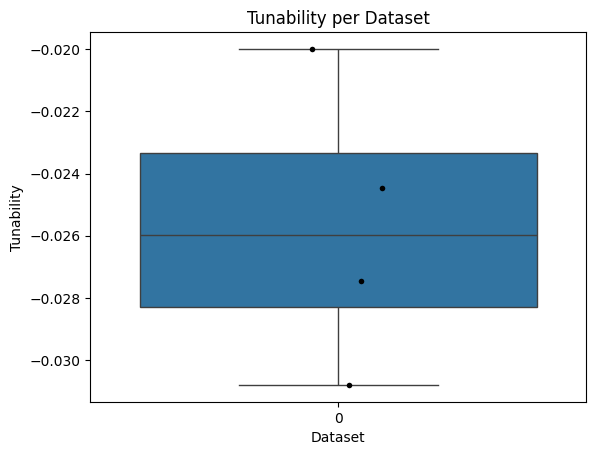

In [28]:
plot_tunability_boxplot(tunability_per_dataset)

In [29]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: -0.02567765700654326


## Find best hyperparameters for given dataset with bayesian search

In [30]:
def get_bayes_search_space_decision_tree():
    return (
        {
            "model__ccp_alpha": Real(0.0, 1.0),
            "model__max_depth": Integer(1, 30),
            "model__min_samples_split": Integer(2, 60),
            "model__min_samples_leaf": Integer(1, 60),
        },
        30,
    )

In [33]:
np.int = np.int64  # hack so numpy doesn't complain about missing np.int :)
# calculate all configs
best_configs, history = find_best_configs_in_search_space_with_bayes(
    search_space=get_bayes_search_space_decision_tree(),
    pipeline=get_decision_tree_pipeline(),
    train_datasets=get_train_datasets(),
)

c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\JAN_CICHOMSKI\STUDIA\STUDIA_SEMESTR_7_2023_ZIMA\auto_ml\homeworks\homework_1\AutoML_HM1\.venv\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 1: Score = 0.6465515830899411
Iteration 2: Score = 0.7806401218620961
Iteration 3: Score = 0.637415846946202
Iteration 4: Score = 0.7913990245351916
Iteration 5: Score = 0.7353508021251304
Iteration 6: Score = 0.7819467475731763
Iteration 7: Score = 0.8603545744348262
Iteration 8: Score = 0.8397762140146794
Iteration 9: Score = 0.7913990245351916
Iteration 10: Score = 0.7860359131759462
Iteration 11: Score = 0.6938644238320535
Iteration 12: Score = 0.6938644238320535
Iteration 13: Score = 0.637415846946202
Iteration 14: Score = 0.7913990245351916
Iteration 15: Score = 0.7819467475731763
Iteration 16: Score = 0.8596859716757758
Iteration 17: Score = 0.8640777323061615
Iteration 18: Score = 0.6938644238320535
Iteration 19: Score = -0.05320919309927987
Iteration 20: Score = 0.872978396636084
Iteration 21: Score = 0.9113384438931316
Iteration 22: Score = 0.9614440191751864
Iteration 23: Score = 0.961116243751512
Iteration 24: Score = 0.7819467475731763
Iteration 25: Score = 0.912

### Plot bayes optimization history for each dataset

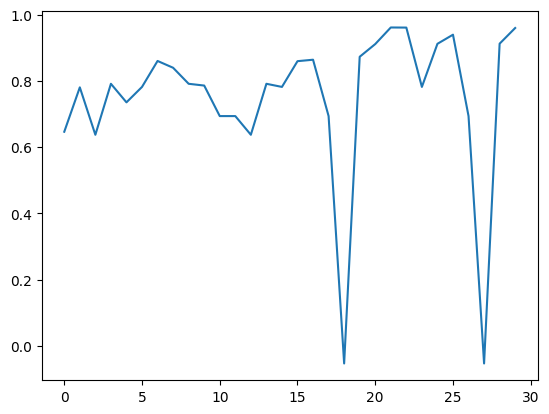

In [36]:
plt.plot(history[0])

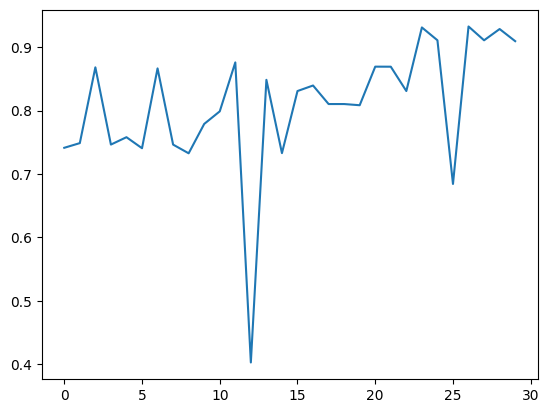

In [37]:
plt.plot(history[1])

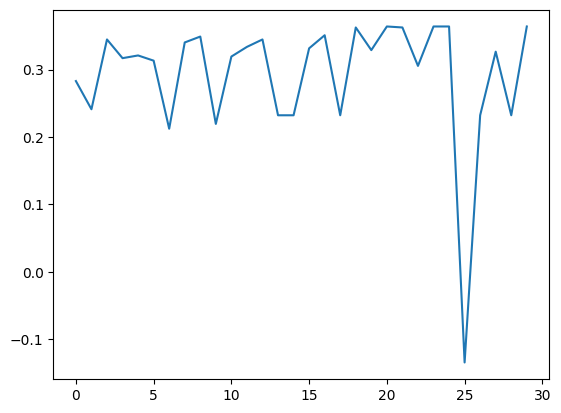

In [38]:
plt.plot(history[2])

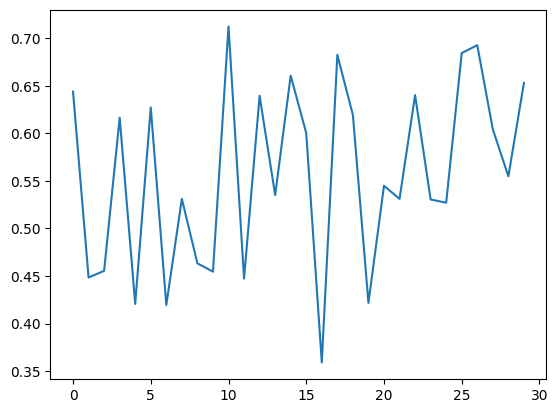

In [39]:
plt.plot(history[3])

## Calculate tunability on each dataset

In [42]:
tunability_per_dataset = calculate_tunability_on_each_set(
    get_train_datasets(), get_test_datasets(), best_configs, optimal_config_decision_tree
)

d^j: 0.004718907759522328
d^j: -0.02786811540003664
d^j: 0.0751095206435396
d^j: 0.10459726027865868


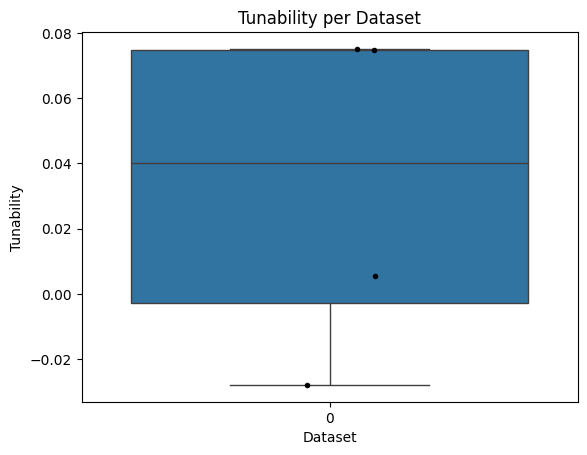

In [40]:
plot_tunability_boxplot(tunability_per_dataset)

In [41]:
# aggregated tunability d
print(
    "Aggregated tunability d: "
    + str(calculate_aggregate_tunability(tunability_per_dataset))
)

Aggregated tunability d: 0.031863636797544254


#### 2. ElasticNet

In [ ]:
def get_elasticnet_pipeline() -> Pipeline:
    elastic_net = ElasticNet(max_iter=10000)
    col_trans: ColumnTransformer = get_column_transformer()
    decision_tree_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", elastic_net)]
    )
    return decision_tree_pipeline

In [ ]:
def get_parameter_grid_for_elasticnet():
    # parameters space
    random.seed(42)
    alpha = [i * 0.05 for i in range(21)]
    l1_ratio = [i * 0.05 for i in range(21)]
    all_combinations = list(
        itertools.product(
            alpha,
            l1_ratio,
        )
    )
    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, 100
    )
    parameter_names = [
        "model__alpha",
        "model__l1_ratio",
    ]

    parameters_grid_elasticnet = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]
    return parameters_grid_elasticnet

In [ ]:
train_datasets: List[Tuple[DataFrame, Series]] = get_train_datasets()
elastic_net_pipeline: Pipeline = get_elasticnet_pipeline()
parameters_grid_elasticnet = get_parameter_grid_for_elasticnet()
optimal_config_elasticnet = find_optimal_configuration_for_all_datasets(
    config_space=parameters_grid_elasticnet,
    train_datasets=train_datasets,
    test_datasets=test_datasets,
    model=elastic_net_pipeline,
    summary_func=np.mean,
)

In [ ]:
print(optimal_config_elasticnet)

In [ ]:
evaluate_pipeline_on_datasets(
    get_elasticnet_pipeline(), optimal_config_elasticnet, train_datasets
)

#### 3. Random Forest

In [ ]:
def get_random_forest_pipeline():
    random_forest = RandomForestRegressor()
    col_trans: ColumnTransformer = get_column_transformer()
    random_forest_pipeline = Pipeline(
        steps=[("column_transformer", col_trans), ("model", random_forest)]
    )
    return random_forest_pipeline

In [ ]:
def get_parameter_grid_for_random_forest():
    # parameters space
    random.seed(42)
    max_depth_values = range(1, 31, 1)
    min_samples_split_values = range(2, 61, 1)
    min_samples_leaf_values = range(1, 61, 1)
    n_estimators_values = range(1, 200, 1)

    all_combinations = list(
        itertools.product(
            max_depth_values,
            min_samples_split_values,
            min_samples_leaf_values,
            n_estimators_values,
        )
    )
    selected_combinations: List[Tuple[float, int, int, int]] = random.sample(
        all_combinations, 100
    )
    parameter_names = [
        "model__max_depth",
        "model__min_samples_split",
        "model__min_samples_leaf",
        "model__n_estimators",
    ]

    parameters_grid_random_forest = [
        dict(zip(parameter_names, combination)) for combination in selected_combinations
    ]
    return parameters_grid_random_forest

In [ ]:
train_datasets: List[Tuple[DataFrame, Series]] = get_train_datasets()
random_forest_pipeline: Pipeline = get_random_forest_pipeline()
parameters_grid_random_forest = get_parameter_grid_for_random_forest()

optimal_config_random_forest = find_optimal_configuration_for_all_datasets(
    config_space=parameters_grid_random_forest,
    train_datasets=train_datasets,
    model=random_forest_pipeline,
    summary_func=np.mean,
)

In [ ]:
print(optimal_config_random_forest)

In [ ]:
evaluate_pipeline_on_datasets(
    get_random_forest_pipeline(), optimal_config_random_forest, train_datasets
)

#TODO
- dla każdej konfiguracje z paratmers_grid trzeba ją porównać do optymalnej

### Bayes - decision tree

In [ ]:
decision_tree_params = {
    "model__ccp_alpha": Real(0.11, 1.21, prior="log-uniform"),
    "model__max_depth": Integer(1, 31, prior="log-uniform"),
    "model__min_samples_split": Integer(2, 61, prior="log-uniform"),
    "model__min_samples_leaf": Integer(2, 61, prior="log-uniform"),
}

In [ ]:
config = find_best_config_using_bayes(
    get_decision_tree_pipeline(),
    [(decision_tree_params, 40)],
    X_train_fish_market,
    y_train_fish_market,
)
model = get_decision_tree_pipeline()
model.set_params(**config)
model.fit(X_train_fish_market, y_train_fish_market)
score = model.score(X_test_fish_market, y_test_fish_market)
print(score)